In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
T1 = torch.tensor([[1,2,3],[2,-0.5,5],[3,5,-0.5]])
g1 = torch.tensor([0.1])
Tn = torch.tensor([[[1,2,3],[2,-0.5,5],[3,5,-0.5]],[[-1,2,3],[2,0.5,5],[3,5,0.5]]])
gn = torch.tensor([0.1,0.2])

In [3]:
print(T1)
print(g1)
print(g1*T1)
print(Tn)
print(Tn.shape)
print(gn)
print(gn.shape)
print(gn.view(-1,1,1).shape)
print(gn.view(-1,1,1))
print(gn.view(-1,1,1)*Tn)

print(gn.view(-1,1,1)*torch.ones_like(Tn))
print(gn.view(-1,1,1)*torch.ones_like(Tn)*Tn)
print(torch.sum(gn.view(-1,1,1)*torch.ones_like(Tn)*Tn,axis=0))

tensor([[ 1.0000,  2.0000,  3.0000],
        [ 2.0000, -0.5000,  5.0000],
        [ 3.0000,  5.0000, -0.5000]])
tensor([0.1000])
tensor([[ 0.1000,  0.2000,  0.3000],
        [ 0.2000, -0.0500,  0.5000],
        [ 0.3000,  0.5000, -0.0500]])
tensor([[[ 1.0000,  2.0000,  3.0000],
         [ 2.0000, -0.5000,  5.0000],
         [ 3.0000,  5.0000, -0.5000]],

        [[-1.0000,  2.0000,  3.0000],
         [ 2.0000,  0.5000,  5.0000],
         [ 3.0000,  5.0000,  0.5000]]])
torch.Size([2, 3, 3])
tensor([0.1000, 0.2000])
torch.Size([2])
torch.Size([2, 1, 1])
tensor([[[0.1000]],

        [[0.2000]]])
tensor([[[ 0.1000,  0.2000,  0.3000],
         [ 0.2000, -0.0500,  0.5000],
         [ 0.3000,  0.5000, -0.0500]],

        [[-0.2000,  0.4000,  0.6000],
         [ 0.4000,  0.1000,  1.0000],
         [ 0.6000,  1.0000,  0.1000]]])
tensor([[[0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000]],

        [[0.2000, 0.2000, 0.2000],
         [0.2000, 0.2000, 

In [4]:

Tn = torch.tensor([[[[1,2,3],[2,-0.5,5],[3,5,-0.5]],[[-1,2,3],[2,0.5,5],[3,5,0.5]]],
                   [[[2,2,3],[2,-1,5],[3,5,-1]],[[-1,2,3],[2,3,7],[3,7,-2]]]])
gn = torch.tensor([[0.1,0.2],[0.3, 0.5]])


print(Tn)
print(Tn.shape)
print(gn)
print(gn.shape)
print(gn.view(-1,2,1,1).shape)
print(gn.view(-1,2,1,1))
print(gn.view(-1,2,1,1)*Tn)

print(gn.view(-1,2,1,1)*torch.ones_like(Tn))
print(gn.view(-1,2,1,1)*torch.ones_like(Tn)*Tn)

print(f'gn: {gn}')
print(f'Tn: {Tn}')
print(f'output: {torch.sum(gn.view(-1,2,1,1)*torch.ones_like(Tn)*Tn,axis=1)}')

tensor([[[[ 1.0000,  2.0000,  3.0000],
          [ 2.0000, -0.5000,  5.0000],
          [ 3.0000,  5.0000, -0.5000]],

         [[-1.0000,  2.0000,  3.0000],
          [ 2.0000,  0.5000,  5.0000],
          [ 3.0000,  5.0000,  0.5000]]],


        [[[ 2.0000,  2.0000,  3.0000],
          [ 2.0000, -1.0000,  5.0000],
          [ 3.0000,  5.0000, -1.0000]],

         [[-1.0000,  2.0000,  3.0000],
          [ 2.0000,  3.0000,  7.0000],
          [ 3.0000,  7.0000, -2.0000]]]])
torch.Size([2, 2, 3, 3])
tensor([[0.1000, 0.2000],
        [0.3000, 0.5000]])
torch.Size([2, 2])
torch.Size([2, 2, 1, 1])
tensor([[[[0.1000]],

         [[0.2000]]],


        [[[0.3000]],

         [[0.5000]]]])
tensor([[[[ 0.1000,  0.2000,  0.3000],
          [ 0.2000, -0.0500,  0.5000],
          [ 0.3000,  0.5000, -0.0500]],

         [[-0.2000,  0.4000,  0.6000],
          [ 0.4000,  0.1000,  1.0000],
          [ 0.6000,  1.0000,  0.1000]]],


        [[[ 0.6000,  0.6000,  0.9000],
          [ 0.6000, -0.3000, 

In [5]:
class TBNN(nn.Module):
    def __init__(self, N: int, input_dim: int, n_hidden: int, neurons: int):
        super().__init__()
        self.N = N
        self.input_dim = input_dim   
        
        self.gn = nn.Linear(neurons,self.N)
        
        self.hidden = nn.ModuleList()
        for k in range(n_hidden):
            self.hidden.append(nn.Linear(input_dim, neurons))
            input_dim = neurons  # For the next layer
                    
    def forward(self, x, Tn):
        for layer in self.hidden:
            x = F.relu(layer(x))
        gn = self.gn(x)
        b_pred = torch.sum(gn.view(-1,self.N,1,1)*torch.ones_like(Tn)*Tn,axis=1)
        return b_pred, gn

In [6]:
tbnn = TBNN(N=2, input_dim=5, n_hidden = 3, neurons = 20)

x = torch.tensor([[0.1, 0.5, 0.6, 0.3, 0.7],[-0.1, -0.5, 0.6, 0.3, -0.7]])
Tn = torch.tensor([[[[1,2,3],[2,-0.5,5],[3,5,-0.5]],[[-1,2,3],[2,0.5,5],[3,5,0.5]]],
                   [[[2,2,3],[2,-1,5],[3,5,-1]],[[-1,2,3],[2,3,7],[3,7,-2]]]])

prediction, gn= tbnn(x,Tn)

print(f'Predictions: {prediction}')
print('\nTest conditions:')
for point in range(x.shape[0]):
    for i in range(0,3):
        for j in range(0,3):
            print(prediction[point,i,j] == gn[point,0]*Tn[point,0,i,j] + gn[point,1]*Tn[point,1,i,j])
print(tbnn)

Predictions: tensor([[[-0.0986, -0.7613, -1.1419],
         [-0.7613,  0.0493, -1.9032],
         [-1.1419, -1.9032,  0.0493]],

        [[-0.4102, -0.7586, -1.1379],
         [-0.7586, -0.0853, -2.1288],
         [-1.1379, -2.1288,  0.4955]]], grad_fn=<SumBackward1>)

Test conditions:
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
TBNN(
  (gn): Linear(in_features=20, out_features=2, bias=True)
  (hidden): ModuleList(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
  )
)


In [7]:
# Zero out testing: training should produce zero gn's:
model = TBNN(N=2, input_dim=5, n_hidden = 3, neurons = 20)

x = torch.tensor([[0.1, 0.5, 0.6, 0.3, 0.7],[-0.1, -0.5, 0.6, 0.3, -0.7]])
Tn = torch.tensor([[[[1,2,3],[2,-0.5,5],[3,5,-0.5]],[[-1,2,3],[2,0.5,5],[3,5,0.5]]],
                   [[[2,2,3],[2,-1,5],[3,5,-1]],[[-1,2,3],[2,3,7],[3,7,-2]]]])
b_label = torch.tensor([[[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0]]])
print(b_label.shape)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
for epoch in range(1000):
    model.train()
    y_pred, gn = model(x, Tn)
    if epoch == 0:
        print(f'First gn: {gn}')
    loss = loss_fn(y_pred.float(), b_label.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(f'Last gn: {gn}')


torch.Size([2, 3, 3])
First gn: tensor([[-0.1926,  0.2924],
        [-0.1657,  0.2821]], grad_fn=<AddmmBackward0>)
Last gn: tensor([[2.4028e-07, 3.8743e-07],
        [2.3283e-07, 4.3958e-07]], grad_fn=<AddmmBackward0>)


In [8]:
# One testing: training should produce gn = 1, 0 in the first case, and 0, 1 in the second case
np.set_printoptions(precision=4,floatmode='fixed')

for test in range(10):
    model = TBNN(N=2, input_dim=5, n_hidden = 3, neurons = 20)

    x = torch.tensor([[0.1, 0.5, 0.6, 0.3, 0.7],[-0.1, -0.5, 0.6, 0.3, -0.7]])
    Tn = torch.tensor([[[[1,2,3],[2,-0.5,5],[3,5,-0.5]],[[-1,2,3],[2,0.5,5],[3,5,0.5]]],
                       [[[2,2,3],[2,-1,5],[3,5,-1]],[[-1,2,3],[2,3,7],[3,7,-2]]]])
    b_label = torch.tensor([[[1,2,3],[2,-0.5,5],[3,5,-0.5]],[[2,2,3],[2,-1,5],[3,5,-1]]])
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    for epoch in range(2000):
        model.train()
        y_pred, gn = model(x, Tn)
        if epoch == 0:
            gn0 = gn
        loss = loss_fn(y_pred.float(), b_label.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Test {test}(a) condition: {(np.abs(np.mean(np.abs(gn[:,0].detach().numpy()- 1))) < 1E-3) & (np.abs(np.mean(np.abs(gn[:,1].detach().numpy()))) < 1E-3)}, first gn: {gn0[:,0].detach().numpy()},{gn0[:,1].detach().numpy()} last gn: {gn[:,0].detach().numpy()},{gn[:,1].detach().numpy()}')

    model = TBNN(N=2, input_dim=5, n_hidden = 3, neurons = 20)

    x = torch.tensor([[0.1, 0.5, 0.6, 0.3, 0.7],[-0.1, -0.5, 0.6, 0.3, -0.7]])
    Tn = torch.tensor([[[[1,2,3],[2,-0.5,5],[3,5,-0.5]],[[-1,2,3],[2,0.5,5],[3,5,0.5]]],
                       [[[2,2,3],[2,-1,5],[3,5,-1]],[[-1,2,3],[2,3,7],[3,7,-2]]]])
    b_label = torch.tensor([[[-1,2,3],[2,0.5,5],[3,5,0.5]],[[-1,2,3],[2,3,7],[3,7,-2]]])
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    for epoch in range(2000):
        model.train()
        y_pred, gn = model(x, Tn)
        if epoch == 0:
            gn0 = gn
        loss = loss_fn(y_pred.float(), b_label.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f'Test {test}(b) condition: {(np.abs(np.mean(np.abs(gn[:,1].detach().numpy()-1))) < 1E-3) & (np.abs(np.mean(np.abs(gn[:,0].detach().numpy()))) < 1E-3)}, first gn: {gn0[:,0].detach().numpy()},{gn0[:,1].detach().numpy()} last gn: {gn[:,0].detach().numpy()},{gn[:,1].detach().numpy()}')


Test 0(a) condition: True, first gn: [0.2579 0.2652],[-0.0976 -0.1416] last gn: [1.0001 1.0001],[-2.1905e-05  4.9412e-05]
Test 0(b) condition: True, first gn: [-0.2216 -0.1881],[0.0009 0.0145] last gn: [-1.4901e-08 -1.4901e-08],[1.0000 1.0000]
Test 1(a) condition: True, first gn: [0.2627 0.2468],[-0.2274 -0.2500] last gn: [1.0000 1.0000],[-1.4901e-08 -1.4901e-08]
Test 1(b) condition: True, first gn: [0.2237 0.2256],[-0.1831 -0.1758] last gn: [0.0000 0.0000],[1.0000 1.0000]
Test 2(a) condition: True, first gn: [0.1724 0.1887],[0.1925 0.2081] last gn: [1.0000 1.0000],[0.0000 0.0000]
Test 2(b) condition: True, first gn: [0.1433 0.1247],[-0.1860 -0.2005] last gn: [-3.7253e-09  1.4901e-08],[1.0000 1.0000]
Test 3(a) condition: True, first gn: [-0.0790 -0.0726],[-0.0546 -0.0875] last gn: [1.0000 1.0000],[0.0000 0.0000]
Test 3(b) condition: True, first gn: [0.1983 0.1976],[0.0106 0.0191] last gn: [-2.9802e-08 -2.9802e-08],[1.0000 1.0000]
Test 4(a) condition: True, first gn: [0.1532 0.1659],[-0

In [9]:
# Memorization testing: model should be able to memorize a random data point
np.set_printoptions(precision=4,floatmode='fixed')
test = 0
tensor_N = 10
br = np.random.uniform(-1,1,size=(2,5))
N_points = 10

def generate_random_antisymmetric_tensors(n_points):
    b = np.empty((n_points,3,3))
    br = np.random.uniform(-1,1,size=(n_points,5))
    for point in range(n_points):
        b[point,0,0] = br[point,0]
        b[point,0,1] = br[point,1]
        b[point,0,2] = br[point,2]
        b[point,1,1] = br[point,3]
        b[point,1,2] = br[point,4]
        b[point,2,2] = -b[point,0,0] - b[point,1,1]
        b[point,1,0] = b[point,0,1]
        b[point,2,0] = b[point,0,2]
        b[point,2,1] = b[point,1,2]
    return b

model = TBNN(N=tensor_N, input_dim=5, n_hidden = 5, neurons = 100)

Tn = np.empty((N_points,tensor_N,3,3))
for point in range(N_points):
    for n in range(tensor_N):
        Tn[point,n,:,:] = generate_random_antisymmetric_tensors(1)
        #print(Tn[0,n,:,:] )
x = torch.tensor(np.random.uniform(-1,1,size=(N_points,5)),dtype = torch.float32)
Tn = torch.tensor(Tn)
b_label = torch.tensor(generate_random_antisymmetric_tensors(N_points))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1500):
    model.train()
    y_pred, gn = model(x, Tn)
    if epoch == 0:
        gn0 = gn
    loss = loss_fn(y_pred.float(), b_label.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
predictions,gn = model(x,Tn)
loss = loss_fn(predictions.float(), b_label.float())
print(f'LOSS: {loss}')
for point in range(N_points): 
    print('\n')
    for i in range(0,3):
        for j in range(0,3):
            print(f'Truth, prediction: {b_label[point][i,j]},{predictions[point][i,j]}, error {abs(b_label[point][i,j] - predictions[point][i,j])}')



LOSS: 0.0002609304792713374


Truth, prediction: -0.686869001091581,-0.6925135188679767, error 0.005644517776395741
Truth, prediction: 0.21012973521889,0.1776430688480815, error 0.03248666637080849
Truth, prediction: 0.6922745508430619,0.7044069998623845, error 0.012132449019322644
Truth, prediction: 0.21012973521889,0.1776430688480815, error 0.03248666637080849
Truth, prediction: 0.8564613655566735,0.8683485093056025, error 0.011887143748928963
Truth, prediction: -0.10033681303563813,-0.10756201803122628, error 0.0072252049955881525
Truth, prediction: 0.6922745508430619,0.7044069998623845, error 0.012132449019322644
Truth, prediction: -0.10033681303563813,-0.10756201803122628, error 0.0072252049955881525
Truth, prediction: -0.16959236446509252,-0.17583499043762596, error 0.006242625972533444


Truth, prediction: 0.887716499093528,0.8762551631355262, error 0.011461335958001806
Truth, prediction: 0.5485454603598465,0.5440657231584218, error 0.004479737201424694
Truth, prediction: -0.854

In [97]:
def myCustomLoss(my_outputs, my_labels):
    #specifying the batch size
    my_batch_size = my_outputs.size()[0]
    #calculating the log of softmax values           
    #my_outputs = ((my_outputs-my_labels)**2).mean()
    #selecting the values that correspond to labels
    #my_outputs = my_outputs[range(my_batch_size), my_labels]
    #returning the results
    return ((my_outputs-my_labels)**2).mean()

def bLoss_equiv_mse(outputs, labels):
    #specifying the batch size
    batch_size = outputs.size()[0]
    se = ((outputs[:,0,0] - labels[:,0,0])**2 \
           + 2*(outputs[:,0,1] - labels[:,0,1])**2 \
           + 2*(outputs[:,0,2] - labels[:,0,2])**2 \
           + (outputs[:,1,1] - labels[:,1,1])**2 \
           + 2*(outputs[:,1,2] - labels[:,1,2])**2 \
           + (outputs[:,2,2] - labels[:,2,2])**2 \
          )/9
    
    #mse = ((torch.diagonal(outputs, dim1=1, dim2=2) - torch.diagonal(labels, dim1=1, dim2=2))**2 + (torch.diagonal(outputs,offset=1, dim1=1, dim2=2) - torch.diagonal(labels, offset=1,dim1=1, dim2=2))**2).mean()
    #calculating the log of softmax values           
    #my_outputs = ((my_outputs-my_labels)**2).mean()
    #selecting the values that correspond to labels
    #my_outputs = my_outputs[range(my_batch_size), my_labels]
    #returning the results
    return se.mean()

def bLoss(outputs, labels, alpha = 1):
    #specifying the batch size
    batch_size = outputs.size()[0]
    se = ((outputs[:,0,0] - labels[:,0,0])**2 \
           + (outputs[:,0,1] - labels[:,0,1])**2 \
           + (outputs[:,0,2] - labels[:,0,2])**2 \
           + (outputs[:,1,1] - labels[:,1,1])**2 \
           + (outputs[:,1,2] - labels[:,1,2])**2 \
           + (outputs[:,2,2] - labels[:,2,2])**2 \
          )/6
    zero = torch.zeros_like(outputs)
    re =  (torch.maximum(torch.maximum(outputs[:,0,0]-2/3, -(outputs[:,0,0] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,1,1]-2/3, -(outputs[:,1,1] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,2,2]-2/3, -(outputs[:,2,2] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,0,1]-1/2, -(outputs[:,0,1] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,0,2]-1/2, -(outputs[:,0,2] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,1,2]-1/2, -(outputs[:,1,2] + 1/2)), zero[:,0,0])**2 \
          )/6

    #mse = ((torch.diagonal(outputs, dim1=1, dim2=2) - torch.diagonal(labels, dim1=1, dim2=2))**2 + (torch.diagonal(outputs,offset=1, dim1=1, dim2=2) - torch.diagonal(labels, offset=1,dim1=1, dim2=2))**2).mean()
    #calculating the log of softmax values           
    #my_outputs = ((my_outputs-my_labels)**2).mean()
    #selecting the values that correspond to labels
    #my_outputs = my_outputs[range(my_batch_size), my_labels]
    #returning the results
    return (se+alpha*re).mean()

def realizabilityLoss(outputs, labels, alpha = 1):
    zero = torch.zeros_like(outputs)
    re =  (torch.maximum(torch.maximum(outputs[:,0,0]-2/3, -(outputs[:,0,0] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,1,1]-2/3, -(outputs[:,1,1] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,2,2]-2/3, -(outputs[:,2,2] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,0,1]-1/2, -(outputs[:,0,1] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,0,2]-1/2, -(outputs[:,0,2] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,1,2]-1/2, -(outputs[:,1,2] + 1/2)), zero[:,0,0])**2 \
          )/6
    return (re).mean()

def realizabilityEigLoss(outputs, labels, alpha = 1):
    eigs = torch.sort(torch.real(torch.linalg.eigvals(outputs)),descending=True)[0]
    #print(eigs)
    #print(eigs[:,1])
    zero = torch.zeros_like(eigs[:,0])
    #if torch.any((3*torch.abs(eigs[:,1])-eigs[:,1])/2 - eigs[:,0]>zero):
    #    print('realizability error 1')
    #if torch.any(eigs[:,0] - (1/3 - eigs[:,0])>zero):
    #    print('realizability error 2')
    re_eig =  (torch.maximum((3*torch.abs(eigs[:,1])-eigs[:,1])/2 - eigs[:,0],zero)**2) \
            + (torch.maximum(eigs[:,0] - (1/3 - eigs[:,0]),zero)**2)
    #print(f'Condition 1: negative {(3*torch.abs(eigs[:,1])-eigs[:,1])/2 - eigs[:,0]}')
    #print(f'Condition 2: negative {eigs[:,0] - (1/3 - eigs[:,0])}')
    #print(f'lambda1 = {eigs[:,0]}, 1/3-lambda2 = {(1/3 - eigs[:,0])}')
    return (re_eig).mean()

def verboserealizabilityEigLoss(outputs, labels, alpha = 1):
    eigs = torch.sort(torch.real(torch.linalg.eigvals(outputs)),descending=True)[0]
    #print(eigs)
    #print(eigs[:,1])
    zero = torch.zeros_like(eigs[:,0])
    if torch.any((3*torch.abs(eigs[:,1])-eigs[:,1])/2 - eigs[:,0]>zero):
        print('realizability error 1')
    if torch.any(eigs[:,0] - (1/3 - eigs[:,0])>zero):
        print('realizability error 2')
    re_eig =  (torch.maximum((3*torch.abs(eigs[:,1])-eigs[:,1])/2 - eigs[:,0],zero)**2) \
            + (torch.maximum(eigs[:,0] - (1/3 - eigs[:,0]),zero)**2)
    print(f'Condition 1: negative {(3*torch.abs(eigs[:,1])-eigs[:,1])/2 - eigs[:,0]}')
    print(f'Condition 2: negative {eigs[:,0] - (1/3 - eigs[:,0])}')
    print(f'lambda1 = {eigs[:,0]}, 1/3-lambda2 = {(1/3 - eigs[:,0])}')
    return (re_eig).mean()

def realizabilityFullLoss(outputs, labels, alpha = 1):
    eigs = torch.sort(torch.real(torch.linalg.eigvals(outputs)),descending=True)[0]
    zero = torch.zeros_like(outputs)
    zero_eig = torch.zeros_like(eigs[:,0])
    re =  (torch.maximum(torch.maximum(outputs[:,0,0]-2/3, -(outputs[:,0,0] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,1,1]-2/3, -(outputs[:,1,1] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,2,2]-2/3, -(outputs[:,2,2] + 1/3)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,0,1]-1/2, -(outputs[:,0,1] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,0,2]-1/2, -(outputs[:,0,2] + 1/2)), zero[:,0,0])**2 \
        + torch.maximum(torch.maximum(outputs[:,1,2]-1/2, -(outputs[:,1,2] + 1/2)), zero[:,0,0])**2 \
          )/6 \
        + (torch.maximum((3*torch.abs(eigs[:,1])-eigs[:,1])/2 - eigs[:,0],zero_eig)**2) \
            + (torch.maximum(eigs[:,0] - (1/3 - eigs[:,0]),zero_eig)**2)
    return (re).mean()


In [16]:
loss_fn = nn.MSELoss()
#loss_fn2 = myCustomLoss()

b_label = torch.tensor([[[-0.9266, -0.9595,  0.6728],
  [-0.9595, -0.2660, -0.3291],
  [ 0.6728, -0.3291,  1.1926]],
 [[ 0.2544,  0.9140,  0.2937],
  [ 0.9140,  0.8664, -0.6828],
  [ 0.2937, -0.6828, -1.1208]]]
)

b_pred = torch.tensor( [[[-0.3729, -0.6638, -0.7964],
  [-0.6638, -0.9099,  0.4229],
  [-0.7964,  0.4229,  1.2828]],
 [[ 0.3710, -0.4268,  0.3966],
  [-0.4268, -0.3257,  0.3040],
  [ 0.3966,  0.3040, -0.0453]]]
)
b_pred = b_label



print(b_label-b_pred)

print((b_label-b_pred)**2)

print(f'torch MSE:       {loss_fn(b_label,b_pred)}')
print(f'Custom mse:      {myCustomLoss(b_label,b_pred)}')
print(f'Equiv symm loss: {bLoss_equiv_mse(b_label,b_pred)}')
print(f'b loss:          {bLoss(b_label,b_pred)}')

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])
torch MSE:       0.0
Custom mse:      0.0
Equiv symm loss: 0.0
b loss:          0.14453168213367462


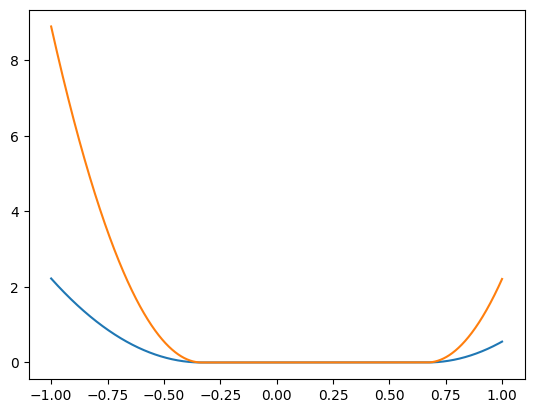

In [12]:
b11 = np.arange(-1,1,0.001)
plt.plot(b11, 5*np.square(np.maximum(b11-2/3,np.maximum(-(b11+1/3),0))))
plt.plot(b11, 20*np.square(np.maximum(b11-2/3,np.maximum(-(b11+1/3),0))))

In [13]:
# Realizability testing: model should be able to predict only realizable points, even given large T's, with only the realizability loss criterion
np.set_printoptions(precision=4,floatmode='fixed')
test = 0
tensor_N = 10
br = np.random.uniform(-1,1,size=(2,5))
N_points = 10

def generate_random_antisymmetric_tensors(n_points):
    b = np.empty((n_points,3,3))
    br = np.random.uniform(-1,1,size=(n_points,5))
    for point in range(n_points):
        b[point,0,0] = br[point,0]
        b[point,0,1] = br[point,1]
        b[point,0,2] = br[point,2]
        b[point,1,1] = br[point,3]
        b[point,1,2] = br[point,4]
        b[point,2,2] = -b[point,0,0] - b[point,1,1]
        b[point,1,0] = b[point,0,1]
        b[point,2,0] = b[point,0,2]
        b[point,2,1] = b[point,1,2]
    return b

model = TBNN(N=tensor_N, input_dim=5, n_hidden = 5, neurons = 100)

Tn = np.empty((N_points,tensor_N,3,3))
for point in range(N_points):
    for n in range(tensor_N):
        Tn[point,n,:,:] = generate_random_antisymmetric_tensors(1)
        #print(Tn[0,n,:,:] )
x = torch.tensor(np.random.uniform(-1,1,size=(N_points,5)),dtype = torch.float32)
Tn = torch.tensor(Tn*10)
b_label = torch.tensor(generate_random_antisymmetric_tensors(N_points))
#loss_fn = realizabilityLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(100):
    model.train()
    y_pred, gn = model(x, Tn)
    if epoch == 0:
        gn0 = gn
    loss = realizabilityLoss(y_pred.float(), b_label.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
predictions,gn = model(x,Tn)
loss = realizabilityLoss(predictions.float(), b_label.float())
print(f'LOSS: {loss}')
for point in range(N_points): 
    print('\n')
    for i in range(0,3):
        for j in range(0,3):
            if i == j:
                if predictions[point][i,j] > 2/3 or predictions[point][i,j]<-1/3:
                    print(f'REALIZABILITY FAILED: b{i+1}{j+1} = {predictions[point][i,j]}')
                else:
                    print(f'Realizable: b{i+1}{j+1} = {predictions[point][i,j]}')
            else: 
                if predictions[point][i,j] > 1/2 or predictions[point][i,j]<-1/2:
                    print(f'REALIZABILITY FAILED: b{i+1}{j+1} = {predictions[point][i,j]}')
                else:
                    print(f'Realizable: b{i+1}{j+1} = {predictions[point][i,j]}')



LOSS: 0.0


Realizable: b11 = 0.19350123170647382
Realizable: b12 = 0.09315907576505346
Realizable: b13 = -0.1652610208161825
Realizable: b21 = 0.09315907576505346
Realizable: b22 = -0.056194284784299706
Realizable: b23 = -0.10723877513320751
Realizable: b31 = -0.1652610208161825
Realizable: b32 = -0.10723877513320751
Realizable: b33 = -0.13730694692217413


Realizable: b11 = -0.05877612237594257
Realizable: b12 = 0.10751129558743991
Realizable: b13 = 0.10474703304830876
Realizable: b21 = 0.10751129558743991
Realizable: b22 = 0.001624663347389252
Realizable: b23 = -0.13920828011556532
Realizable: b31 = 0.10474703304830876
Realizable: b32 = -0.13920828011556532
Realizable: b33 = 0.05715145902855334


Realizable: b11 = -0.10199634709189807
Realizable: b12 = -0.014325732278433546
Realizable: b13 = 0.003593085877485411
Realizable: b21 = -0.014325732278433546
Realizable: b22 = 0.11951284578996049
Realizable: b23 = -0.1258699228293364
Realizable: b31 = 0.003593085877485411
Realizable: b32 = 

In [88]:
b_label = torch.tensor([[[-0.9266, -0.9595,  0.6728],
  [-0.9595, -0.2660, -0.3291],
  [ 0.6728, -0.3291,  1.1926]],
 [[ 0.2544,  0.9140,  0.2937],
  [ 0.9140,  0.8664, -0.6828],
  [ 0.2937, -0.6828, -1.1208]]]
)

b_pred = torch.tensor( [[[-0.3729, -0.6638, -0.7964],
  [-0.6638, -0.9099,  0.4229],
  [-0.7964,  0.4229,  1.2828]],
 [[ 0.3710, -0.4268,  0.3966],
  [-0.4268, -0.3257,  0.3040],
  [ 0.3966,  0.3040, -0.0453]]]
)

loss = 0.0
while loss == 0:
    b_label = torch.tensor(generate_random_antisymmetric_tensors(3))
    b_pred = torch.tensor(generate_random_antisymmetric_tensors(3))
    loss = realizabilityEigLoss(b_pred,b_label)

#print(realizabilityEigLoss(b_pred,b_label))

realizability error 2
Condition 1: negative tensor([-0.6010, -0.6870, -0.4884], dtype=torch.float64)
Condition 2: negative tensor([3.0849, 1.8264, 2.0122], dtype=torch.float64)
lambda1 = tensor([1.7091, 1.0799, 1.1727], dtype=torch.float64), 1/3-lambda2 = tensor([-1.3758, -0.7465, -0.8394], dtype=torch.float64)


In [96]:
# Realizability testing: model should be able to predict only realizable points, even given large T's, with only the realizability loss criterion
np.set_printoptions(precision=4,floatmode='fixed')
test = 0
tensor_N = 10
br = np.random.uniform(-1,1,size=(2,5))
N_points = 10

def generate_random_antisymmetric_tensors(n_points):
    b = np.empty((n_points,3,3))
    br = np.random.uniform(-1,1,size=(n_points,5))
    for point in range(n_points):
        b[point,0,0] = br[point,0]
        b[point,0,1] = br[point,1]
        b[point,0,2] = br[point,2]
        b[point,1,1] = br[point,3]
        b[point,1,2] = br[point,4]
        b[point,2,2] = -b[point,0,0] - b[point,1,1]
        b[point,1,0] = b[point,0,1]
        b[point,2,0] = b[point,0,2]
        b[point,2,1] = b[point,1,2]
    return b

model = TBNN(N=tensor_N, input_dim=5, n_hidden = 5, neurons = 100)

Tn = np.empty((N_points,tensor_N,3,3))
for point in range(N_points):
    for n in range(tensor_N):
        Tn[point,n,:,:] = generate_random_antisymmetric_tensors(1)
        #print(Tn[0,n,:,:] )
x = torch.tensor(np.random.uniform(-1,1,size=(N_points,5)),dtype = torch.float32)
Tn = torch.tensor(Tn*10)
b_label = torch.tensor(generate_random_antisymmetric_tensors(N_points))
#loss_fn = realizabilityLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
y_pred, gn = model(x, Tn)
loss = verboserealizabilityEigLoss(y_pred.float(), b_label.float())
print(f'LOSS: {loss}')
for epoch in range(100):
    model.train()
    y_pred, gn = model(x, Tn)
    if epoch == 0:
        gn0 = gn
    loss = realizabilityEigLoss(y_pred.float(), b_label.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
predictions,gn = model(x,Tn)
print('After training:')
loss = verboserealizabilityEigLoss(predictions.float(), b_label.float())
print(f'LOSS: {loss}')
for point in range(N_points): 
    print('\n')
    for i in range(0,3):
        for j in range(0,3):
            if i == j:
                if predictions[point][i,j] > 2/3 or predictions[point][i,j]<-1/3:
                    print(f'REALIZABILITY FAILED: b{i+1}{j+1} = {predictions[point][i,j]}')
                else:
                    print(f'Realizable: b{i+1}{j+1} = {predictions[point][i,j]}')
            else: 
                if predictions[point][i,j] > 1/2 or predictions[point][i,j]<-1/2:
                    print(f'REALIZABILITY FAILED: b{i+1}{j+1} = {predictions[point][i,j]}')
                else:
                    print(f'Realizable: b{i+1}{j+1} = {predictions[point][i,j]}')



realizability error 2
Condition 1: negative tensor([-2.3589, -1.8967, -1.5408, -1.6887, -0.7248, -2.3956, -1.1776, -1.0277,
        -1.8560, -3.0236], grad_fn=<SubBackward0>)
Condition 2: negative tensor([4.8764, 5.2417, 4.0394, 6.6526, 3.6441, 4.6776, 6.3912, 4.4254, 6.2655,
        6.0138], grad_fn=<SubBackward0>)
lambda1 = tensor([2.6049, 2.7875, 2.1864, 3.4930, 1.9887, 2.5055, 3.3623, 2.3793, 3.2994,
        3.1735], grad_fn=<SelectBackward0>), 1/3-lambda2 = tensor([-2.2715, -2.4542, -1.8530, -3.1596, -1.6554, -2.1721, -3.0289, -2.0460,
        -2.9661, -2.8402], grad_fn=<RsubBackward1>)
LOSS: 28.284103393554688
After training:
Condition 1: negative tensor([-0.1373, -0.0949, -0.1091, -0.1123, -0.1164, -0.1244, -0.0681, -0.0196,
        -0.0485, -0.1108], grad_fn=<SubBackward0>)
Condition 2: negative tensor([-0.0480, -0.0837, -0.0763, -0.0981, -0.0955, -0.0513, -0.0174, -0.2046,
        -0.1821, -0.0877], grad_fn=<SubBackward0>)
lambda1 = tensor([0.1427, 0.1248, 0.1285, 0.1176, 0.11

In [108]:
# Realizability testing: model should be able to predict only realizable points, even given large T's, with only the realizability loss criterion
np.set_printoptions(precision=4,floatmode='fixed')
test = 0
tensor_N = 10
br = np.random.uniform(-1,1,size=(2,5))
N_points = 10

def generate_random_antisymmetric_tensors(n_points):
    b = np.empty((n_points,3,3))
    br = np.random.uniform(-1,1,size=(n_points,5))
    for point in range(n_points):
        b[point,0,0] = br[point,0]
        b[point,0,1] = br[point,1]
        b[point,0,2] = br[point,2]
        b[point,1,1] = br[point,3]
        b[point,1,2] = br[point,4]
        b[point,2,2] = -b[point,0,0] - b[point,1,1]
        b[point,1,0] = b[point,0,1]
        b[point,2,0] = b[point,0,2]
        b[point,2,1] = b[point,1,2]
    return b

model = TBNN(N=tensor_N, input_dim=5, n_hidden = 5, neurons = 100)

Tn = np.empty((N_points,tensor_N,3,3))
for point in range(N_points):
    for n in range(tensor_N):
        Tn[point,n,:,:] = generate_random_antisymmetric_tensors(1)
        #print(Tn[0,n,:,:] )
x = torch.tensor(np.random.uniform(-1,1,size=(N_points,5)),dtype = torch.float32)
Tn = torch.tensor(Tn*10)
b_label = torch.tensor(generate_random_antisymmetric_tensors(N_points))
#loss_fn = realizabilityLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
y_pred, gn = model(x, Tn)
loss = realizabilityFullLoss(y_pred.float(), b_label.float())
print(f'LOSS: {loss}')
for epoch in range(100):
    model.train()
    y_pred, gn = model(x, Tn)
    if epoch == 0:
        gn0 = gn
    loss = realizabilityFullLoss(y_pred.float(), b_label.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
predictions,gn = model(x,Tn)
print('After training:')
loss = realizabilityFullLoss(predictions.float(), b_label.float())
print(f'LOSS: {loss}')
loss = verboserealizabilityEigLoss(predictions.float(), b_label.float())
print(f'verbose LOSS: {loss}')
for point in range(N_points): 
    print('\n')
    for i in range(0,3):
        for j in range(0,3):
            if i == j:
                if predictions[point][i,j] > 2/3 or predictions[point][i,j]<-1/3:
                    print(f'REALIZABILITY FAILED: b{i+1}{j+1} = {predictions[point][i,j]}')
                else:
                    print(f'Realizable: b{i+1}{j+1} = {predictions[point][i,j]}')
            else: 
                if predictions[point][i,j] > 1/2 or predictions[point][i,j]<-1/2:
                    print(f'REALIZABILITY FAILED: b{i+1}{j+1} = {predictions[point][i,j]}')
                else:
                    print(f'Realizable: b{i+1}{j+1} = {predictions[point][i,j]}')



LOSS: 9.804380416870117
After training:
LOSS: 0.0
Condition 1: negative tensor([-0.1121, -0.0891, -0.1022, -0.0913, -0.0730, -0.0942, -0.0416, -0.0805,
        -0.0782, -0.0533], grad_fn=<SubBackward0>)
Condition 2: negative tensor([-0.0846, -0.1010, -0.1193, -0.0333, -0.1243, -0.0846, -0.0595, -0.1278,
        -0.1631, -0.2177], grad_fn=<SubBackward0>)
lambda1 = tensor([0.1244, 0.1162, 0.1070, 0.1500, 0.1045, 0.1244, 0.1369, 0.1028, 0.0851,
        0.0578], grad_fn=<SelectBackward0>), 1/3-lambda2 = tensor([0.2089, 0.2171, 0.2263, 0.1833, 0.2288, 0.2089, 0.1964, 0.2305, 0.2482,
        0.2755], grad_fn=<RsubBackward1>)
verbose LOSS: 0.0


Realizable: b11 = -0.10453618503725141
Realizable: b12 = 0.04618557290716444
Realizable: b13 = -0.042389234325317084
Realizable: b21 = 0.04618557290716444
Realizable: b22 = 0.08130364814994266
Realizable: b23 = 0.06467997594624128
Realizable: b31 = -0.042389234325317084
Realizable: b32 = 0.06467997594624128
Realizable: b33 = 0.02323253688730876


Real